In [31]:
# Run this cell
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%matplotlib inline
import re
import nltk
import string
# run this in cmd to avoid an error beforehand for this import
# python -m nltk.downloader stopwords punkt
from nltk.corpus import stopwords

import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support


In [32]:
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


In [33]:
df = pd.read_csv('train.csv')
df["text"] = df["text"].str.lower()
df["text"] = df["text"].apply(lambda text: remove_urls(text))
df["text"] = df["text"].apply(lambda text: remove_punctuation(text))
df["text"] = df["text"].apply(lambda text: remove_stopwords(text))
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [34]:
def randNoun(lines):
    # function to test if something is a noun
    is_noun = lambda pos: pos[:2] == 'NN'
    # do the nlp stuff
    tokenized = nltk.word_tokenize(lines)
    nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
    if (len(nouns) == 0): # if no nouns picked up return rand word in text
        return lines[random.randrange(len(lines))]
    return nouns[random.randrange(len(nouns))]

In [35]:
# preprocessing of the dataset
print(len(df["location"]))
words = {} # will hold unique keywords
count = 0
# getting rid of %20 in keyword and getting a list of all the unqiue keywords
for i in df["keyword"]:
    i = str(i).replace("%20", ' ')
    if (i not in words.keys() and i != "nan"):
        words[i] = count
        count+=1

# filling in missing feature values
# missing keywords get filled in with a keywords already in "words" if that keyword shows up in text, otherwise pick a random word from text
# Missing "location" gets filled in with "Earth"
for i,j in df.iterrows():
    if (pd.isna(j["keyword"])):
        for k in words.keys():
            if k in j["text"]:
                df.at[i, "keyword"] = k
            else:
                df.at[i, "keyword"] = randNoun(j["text"])
    if (pd.isna(j["location"])):
        df.at[i, "location"] = "Earth"
# for i, j in df.iterrows():
#     if (pd.isna(j["location"])):
#         df.drop(i, axis=0, inplace=True)

print(len(df["text"]))


7613
7613


In [36]:
# df.reset_index(inplace=True, drop=True)
# df.head()


In [37]:
# we are going to feature transform 
corpus = df["text"].to_list() # combine all text to a bag of words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).toarray() # TF-IDF text encoding



#doing hot and cold encoding for keywords
words = {} # will hold unique keywords with a corresponding index
count = 0
for i in df["keyword"]:
    if (i not in words.keys()):
        words[i] = count
        count+=1
print(words)
keywords_hot_cold = np.zeros((len(df["keyword"]), len(words.keys()))) # init feature shape
for i in range(keywords_hot_cold.shape[0]):
    row = np.zeros(keywords_hot_cold.shape[1])
    row[words[df.at[i, "keyword"]]] = 1 # using the index found in the dict, index the row and set the corresponding value of the keyword to 1
    keywords_hot_cold[i] = row


#doing hot and cold encoding for locations
locations = {}
count = 0
for i in df["location"]:
    if (i not in locations.keys()):
        locations[i] = count
        count+=1
location_hot_cold = np.zeros((len(df["location"]), len(locations.keys())))
for i in range(location_hot_cold.shape[0]):
    row = np.zeros(location_hot_cold.shape[1])
    row[locations[df.at[i, "location"]]] = 1
    location_hot_cold[i] = row



# print(np.max(locations_vector))




{'earthquake': 0, 'canada': 1, 'officers': 2, 'wildfires': 3, 'photo': 4, 'california': 5, 'rain': 6, 'fire': 7, 'evacuation': 8, 'area': 9, 'heat': 10, 'flooding': 11, 'days': 12, 'bago': 13, 'multi': 14, 'man': 15, 'fruits': 16, 'summer': 17, 'car': 18, 'goooooooaaaaaal': 19, 'l': 20, 'london': 21, 'skiing': 22, 'day': 23, 'looooool': 24, 'wayi': 25, 'week': 26, 'girlfriend': 27, 'cooool': 28, 'pasta': 29, 'end': 30, 'ablaze': 31, 'accident': 32, 'aftershock': 33, 'airplane%20accident': 34, 'ambulance': 35, 'annihilated': 36, 'annihilation': 37, 'apocalypse': 38, 'armageddon': 39, 'army': 40, 'arson': 41, 'arsonist': 42, 'attack': 43, 'attacked': 44, 'avalanche': 45, 'battle': 46, 'bioterror': 47, 'bioterrorism': 48, 'blaze': 49, 'blazing': 50, 'bleeding': 51, 'blew%20up': 52, 'blight': 53, 'blizzard': 54, 'blood': 55, 'bloody': 56, 'blown%20up': 57, 'body%20bag': 58, 'body%20bagging': 59, 'body%20bags': 60, 'bomb': 61, 'bombed': 62, 'bombing': 63, 'bridge%20collapse': 64, 'buildings

In [38]:
# combine all features and split into training and validation sets

X = np.hstack((keywords_hot_cold, location_hot_cold, X))
# scalar = StandardScaler()
# scalar.fit(X)
# X = scalar.fit_transform(X)
# X = keywords_hot_cold
# X_train = X
# y_train = df["target"]
X = X**2
X_train, X_val,  y_train, y_val = train_test_split(X, df["target"], test_size=.4)

# X_train = scalar.fit_transform(X_train)
# X_val = scalar.fit_transform(X_val)

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()


# poly = PolynomialFeatures(1)
# X_train = poly.fit_transform(X_train)
# X_val = poly.fit_transform(X_val)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(4567, 21323) (4567,) (3046, 21323) (3046,)


In [39]:
lmdas = [.002, .001, .0005, .0001, .00001, .000005]

penalty = ['l1', 'l2']


In [40]:
from sklearn import linear_model
results = []
for pen in range(len(penalty)):
    results.append([])
    for lmda in range(len(lmdas)):
        results[pen].append([])
        logreg = linear_model.SGDClassifier(penalty = penalty[pen], alpha = lmdas[lmda], max_iter=2000, loss="log_loss")
        logreg.fit(X_train, y_train)
        w_logreg = logreg.coef_
        y_hat_logreg = logreg.predict(X_val)
        # Find the accuracy achieved on test set using logreg.score and y_test 
        
        acc_train = logreg.score(X_train, y_train)
        acc_logreg = logreg.score(X_val, y_val)
        prec, recal, fscore, sup =  precision_recall_fscore_support(y_val, y_hat_logreg, zero_division=True)
        results[pen][lmda].append( {"acc_train": acc_train, "acc_val": acc_logreg, "prec": prec, "recal": recal, "weights":np.sum(w_logreg) + logreg.intercept_[0]})
        print( {"acc_train": acc_train, "acc_val": acc_logreg, "prec": prec, "recal": recal, "weights":np.sum(w_logreg) + logreg.intercept_[0]})


{'acc_train': 0.6074009196409021, 'acc_val': 0.6126066973079448, 'prec': array([0.59910837, 0.91538462]), 'recal': array([0.99374289, 0.0923913 ]), 'weights': 6.71305925387869}
{'acc_train': 0.7024304795270419, 'acc_val': 0.6766250820748523, 'prec': array([0.65641441, 0.76347826]), 'recal': array([0.92263936, 0.34083851]), 'weights': 22.910303712936916}
{'acc_train': 0.7455660170790454, 'acc_val': 0.7176625082074852, 'prec': array([0.71607315, 0.72107438]), 'recal': array([0.84641638, 0.54192547]), 'weights': 24.57947175696595}
{'acc_train': 0.8359973724545654, 'acc_val': 0.7242284963887065, 'prec': array([0.73111782, 0.71132075]), 'recal': array([0.82593857, 0.58540373]), 'weights': 178.2316203758774}
{'acc_train': 0.9881760455441209, 'acc_val': 0.7495075508864084, 'prec': array([0.77023357, 0.71784232]), 'recal': array([0.80659841, 0.67158385]), 'weights': 1328.1454328967811}
{'acc_train': 0.9956207576089336, 'acc_val': 0.7518056467498359, 'prec': array([0.78114478, 0.71044304]), 're

In [41]:
print(repr(results))
for i in results:
    print('\n')
    for j in i:
        print(j)



[[[{'acc_train': 0.6074009196409021, 'acc_val': 0.6126066973079448, 'prec': array([0.59910837, 0.91538462]), 'recal': array([0.99374289, 0.0923913 ]), 'weights': 6.71305925387869}], [{'acc_train': 0.7024304795270419, 'acc_val': 0.6766250820748523, 'prec': array([0.65641441, 0.76347826]), 'recal': array([0.92263936, 0.34083851]), 'weights': 22.910303712936916}], [{'acc_train': 0.7455660170790454, 'acc_val': 0.7176625082074852, 'prec': array([0.71607315, 0.72107438]), 'recal': array([0.84641638, 0.54192547]), 'weights': 24.57947175696595}], [{'acc_train': 0.8359973724545654, 'acc_val': 0.7242284963887065, 'prec': array([0.73111782, 0.71132075]), 'recal': array([0.82593857, 0.58540373]), 'weights': 178.2316203758774}], [{'acc_train': 0.9881760455441209, 'acc_val': 0.7495075508864084, 'prec': array([0.77023357, 0.71784232]), 'recal': array([0.80659841, 0.67158385]), 'weights': 1328.1454328967811}], [{'acc_train': 0.9956207576089336, 'acc_val': 0.7518056467498359, 'prec': array([0.78114478,

[[{'acc_train': 0.6074009196409021, 'acc_val': 0.6126066973079448, 'prec': array([0.59910837, 0.91538462]), 'recal': array([0.99374289, 0.0923913 ]), 'weights': 6.71305925387869}], [{'acc_train': 0.7024304795270419, 'acc_val': 0.6766250820748523, 'prec': array([0.65641441, 0.76347826]), 'recal': array([0.92263936, 0.34083851]), 'weights': 22.910303712936916}], [{'acc_train': 0.7455660170790454, 'acc_val': 0.7176625082074852, 'prec': array([0.71607315, 0.72107438]), 'recal': array([0.84641638, 0.54192547]), 'weights': 24.57947175696595}], [{'acc_train': 0.8359973724545654, 'acc_val': 0.7242284963887065, 'prec': array([0.73111782, 0.71132075]), 'recal': array([0.82593857, 0.58540373]), 'weights': 178.2316203758774}], [{'acc_train': 0.9881760455441209, 'acc_val': 0.7495075508864084, 'prec': array([0.77023357, 0.71784232]), 'recal': array([0.80659841, 0.67158385]), 'weights': 1328.1454328967811}], [{'acc_train': 0.9956207576089336, 'acc_val': 0.7518056467498359, 'prec': array([0.78114478, 

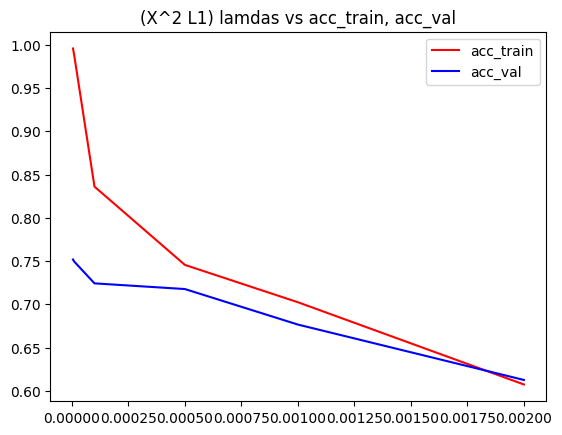

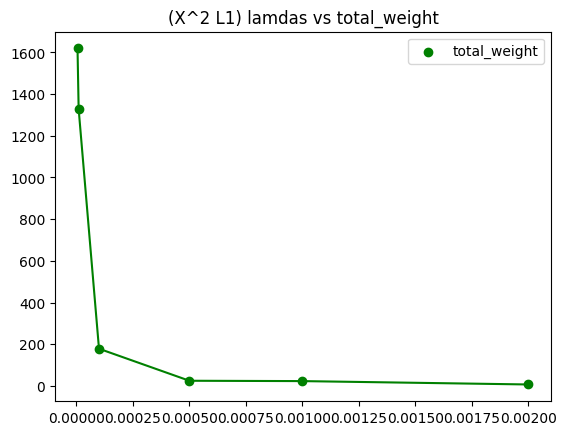

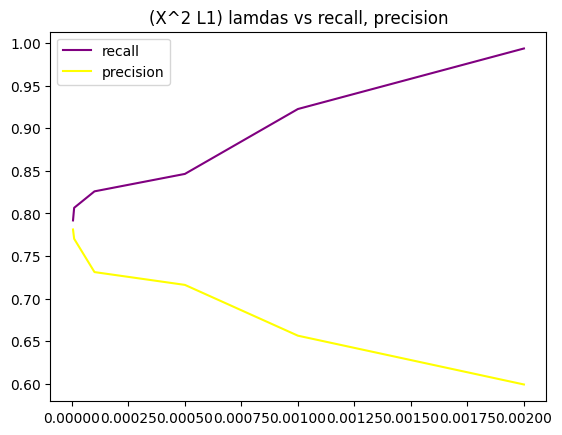

In [42]:
acc_train = []
acc_val = []
weights = []
recall = []
prec = []
specific_result = results[0]
print(specific_result)
for i in range(len(results[0])):
    acc_train.append(specific_result[i][0]["acc_train"])
    acc_val.append(specific_result[i][0]["acc_val"])
    weights.append(specific_result[i][0]["weights"])
    recall.append(specific_result[i][0]["recal"][0])
    prec.append(specific_result[i][0]["prec"][0])

plt.title("(X^2 L1) lamdas vs acc_train, acc_val")
# plt.scatter(lmdas, l1acc_train, color='red', label="acc_train")
# plt.scatter(lmdas, l1acc_val, color='blue', label="acc_val")
plt.plot(lmdas, acc_train, color='red', label = "acc_train")
plt.plot(lmdas, acc_val, color='blue', label = "acc_val")
plt.legend()
plt.show()

plt.title("(X^2 L1) lamdas vs total_weight")
plt.scatter(lmdas, weights, color='green', label="total_weight")
plt.plot(lmdas, weights, color='green')
plt.legend()
plt.show()


plt.title("(X^2 L1) lamdas vs recall, precision")
# plt.scatter(lmdas, l1recall, color='purple',label="recall")
# plt.scatter(lmdas, l1prec, color='yellow', label="precision")
plt.plot(lmdas, recall, color='purple',label="recall")
plt.plot(lmdas, prec, color='yellow', label="precision")
plt.legend()
plt.show()

[[{'acc_train': 0.7753448653382965, 'acc_val': 0.7212738017071569, 'prec': array([0.71149372, 0.74470457]), 'recal': array([0.86973834, 0.51863354]), 'weights': -0.18248151733145793}], [{'acc_train': 0.7941756076198817, 'acc_val': 0.7337491792514773, 'prec': array([0.73592427, 0.72954764]), 'recal': array([0.84015927, 0.58850932]), 'weights': -0.24349443574366825}], [{'acc_train': 0.8053426757171009, 'acc_val': 0.7334208798424163, 'prec': array([0.73415842, 0.73196881]), 'recal': array([0.84357224, 0.58307453]), 'weights': -0.53628464256645}], [{'acc_train': 0.8931464856579812, 'acc_val': 0.7353906762967827, 'prec': array([0.76771654, 0.69006309]), 'recal': array([0.77645051, 0.67934783]), 'weights': 0.026798365791208922}], [{'acc_train': 0.972410772936282, 'acc_val': 0.7409717662508207, 'prec': array([0.78349912, 0.68661182]), 'recal': array([0.76166098, 0.71273292]), 'weights': 0.5762399277189035}], [{'acc_train': 0.9903656667396541, 'acc_val': 0.7396585686145765, 'prec': array([0.78

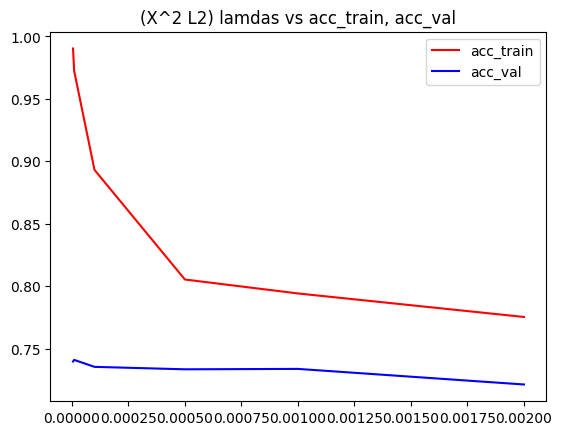

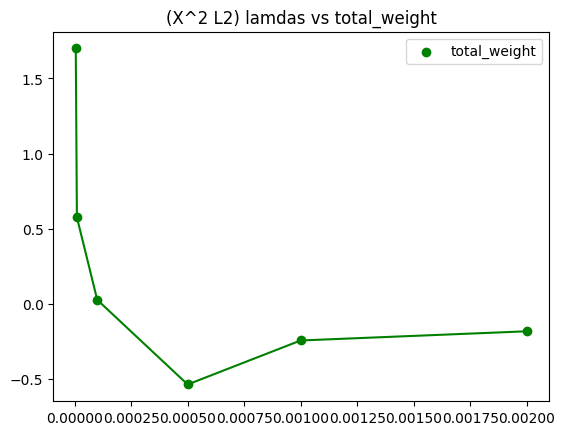

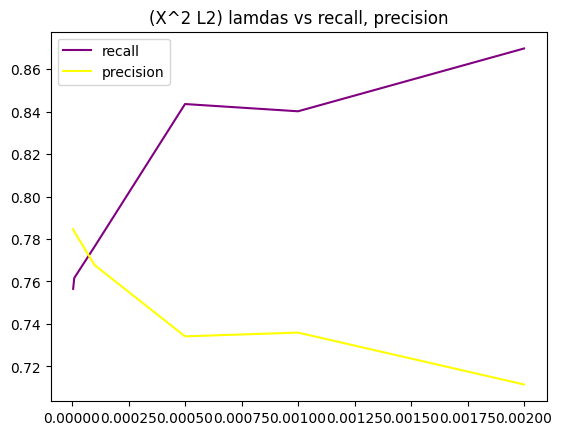

In [43]:
acc_train = []
acc_val = []
weights = []
recall = []
prec = []
specific_result = results[1]
print(specific_result)
for i in range(len(results[1])):
    acc_train.append(specific_result[i][0]["acc_train"])
    acc_val.append(specific_result[i][0]["acc_val"])
    weights.append(specific_result[i][0]["weights"])
    recall.append(specific_result[i][0]["recal"][0])
    prec.append(specific_result[i][0]["prec"][0])



plt.title("(X^2 L2) lamdas vs acc_train, acc_val")
# plt.scatter(lmdas, l1acc_train, color='red', label="acc_train")
# plt.scatter(lmdas, l1acc_val, color='blue', label="acc_val")

plt.plot(lmdas, acc_train, color='red', label="acc_train")
plt.plot(lmdas, acc_val, color='blue', label="acc_val")
plt.legend()
plt.show()

plt.title("(X^2 L2) lamdas vs total_weight")
plt.scatter(lmdas, weights, color='green', label="total_weight")
plt.plot(lmdas, weights, color='green')
plt.legend()
plt.show()


plt.title("(X^2 L2) lamdas vs recall, precision")
# plt.scatter(lmdas, l1recall, color='purple',label="recall")
# plt.scatter(lmdas, l1prec, color='yellow', label="precision")
plt.plot(lmdas, recall, color='purple',label="recall")
plt.plot(lmdas, prec, color='yellow', label="precision")
plt.legend()
plt.show()